# Catalog partition size distribution

**Author**: Melissa DeLucchi

In this notebook, we explore both the on-disk and number-of-rows size comparisons for individual partitions in a large (~8T) hipscat catalog.

First, we take our time building a dataframe that has all of the relevant data points for each partition:
- number of rows
- number of row groups
- size of the leaf parquet file on disk

In [1]:
%%time

import hipscat
import os
from hipscat.pixel_math import HealpixPixel
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import pyarrow.parquet as pq
import pandas as pd
from hipscat.inspection import plot_pixel_list, plot_pixels

### Change this path!!!
catalog_dir = "/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_zource/"

catalog = hipscat.read_from_hipscat(catalog_dir)
info_frame = catalog.partition_info.as_dataframe()
for index, partition in info_frame.iterrows():
    file_name = result = hipscat.io.paths.pixel_catalog_file(
        catalog_dir, partition["Norder"], partition["Npix"]
    )
    info_frame.loc[index, "size_on_disk"] = os.path.getsize(file_name)

info_frame = info_frame.astype(int)
info_frame["gbs"] = info_frame["size_on_disk"] / (1024 * 1024 * 1024)

CPU times: user 14.2 s, sys: 15.1 s, total: 29.4 s
Wall time: 15.6 s


## Number of rows per file

This is silly and non-pythonic. Oh well.

Read through our `_metadata` file, and build up the data points we can there. 

Note that some partition files contain more than one row group, just because of how parquet does things under the hood. We try to capture which pixels exhibit this behavior.

In [2]:
%%time

metadata_file = "/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_zource/_metadata"

total_metadata = pq.read_metadata(metadata_file)
num_row_groups = total_metadata.num_row_groups
first_row_group = total_metadata.row_group(0)
norder_column = -1
npix_column = -1

for i in range(0, first_row_group.num_columns):
    column = first_row_group.column(i)
    if column.path_in_schema == "Norder":
        norder_column = i
    elif column.path_in_schema == "Npix":
        npix_column = i

if norder_column == -1 or npix_column == -1:
    raise ValueError("Metadata missing Norder or Npix column")

row_group_index = np.arange(0, num_row_groups)

pixel_tuples = [
    (
        total_metadata.row_group(index).column(norder_column).statistics.min,
        total_metadata.row_group(index).column(npix_column).statistics.min,
        total_metadata.row_group(index).num_rows,
        1,
    )
    for index in row_group_index
]

num_row_groups

CPU times: user 37.2 s, sys: 9.62 s, total: 46.8 s
Wall time: 46.9 s


565212

In [3]:
pixel_frame = pd.DataFrame(pixel_tuples, columns=["Norder", "Npix", "num_rows", "num_groups"])
pixel_frame = pixel_frame.groupby(["Norder", "Npix"]).sum()

merged_frame = pixel_frame.merge(info_frame.set_index(["Norder", "Npix"]),left_index=True, right_index=True).reset_index()
merged_frame

,Norder,Npix,num_rows,num_groups,Dir,size_on_disk,gbs
0,2,137,17440,1,0,526717,0.000491
1,2,138,2378,1,0,108704,0.000101
2,3,257,8548413,9,0,145378668,0.135394
3,3,258,8922414,9,0,150280437,0.139960
4,3,322,21422932,21,0,344904892,0.321218
...,...,...,...,...,...,...,...
41674,9,1963827,9816685,10,1960000,157422489,0.146611
41675,9,1963828,9083004,9,1960000,145308576,0.135329
41676,9,1963829,8486393,9,1960000,135652043,0.126336
41677,9,1963830,9063572,9,1960000,145009040,0.135050


## Sky map plotting

Let's look at the three per-partition metrics we have

In [4]:
def plot_sky_frame(info_frame, title, column_of_interest):
    max_order = int(info_frame["Norder"].max())
    order_map = np.full(hp.order2npix(max_order), hp.pixelfunc.UNSEEN)
    for _, partition in info_frame.iterrows():
        pixel = HealpixPixel(int(partition["Norder"]), int(partition["Npix"]))
        explosion_factor = 4 ** (max_order - pixel.order)
        exploded_pixels = [
            *range(
                pixel.pixel * explosion_factor,
                (pixel.pixel + 1) * explosion_factor,
            )
        ]
        order_map[exploded_pixels] = partition[column_of_interest]
    hp.mollview(order_map,
        title=title,
        nest=True,
    )
    plt.plot()

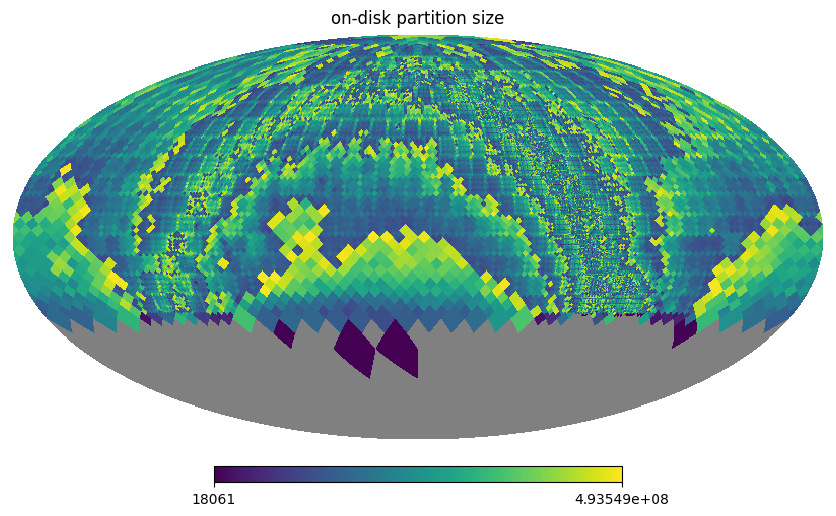

In [5]:
plot_sky_frame(merged_frame, "on-disk partition size", "size_on_disk")

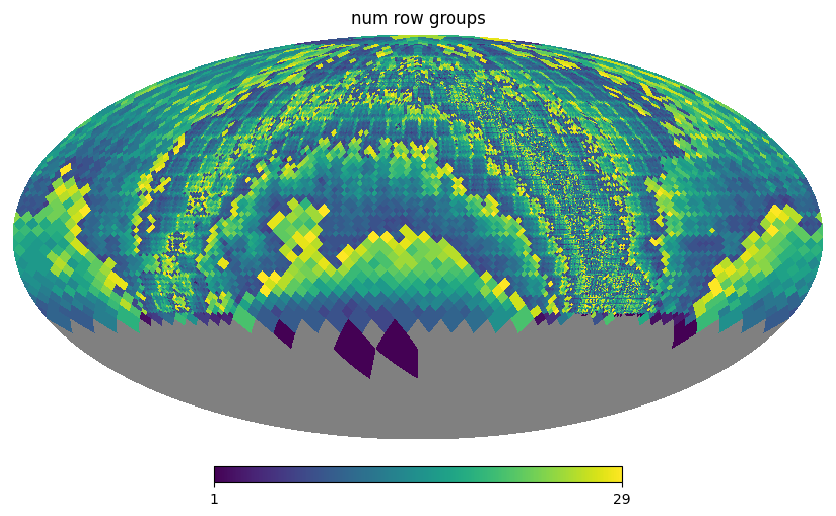

In [6]:
plot_sky_frame(merged_frame, "num row groups", "num_groups")

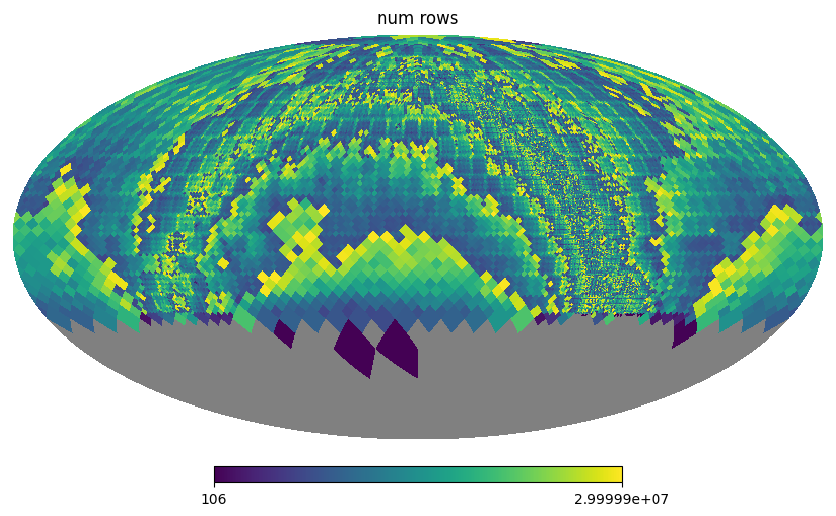

In [7]:
plot_sky_frame(merged_frame, "num rows", "num_rows")

## So, what's happening here?

### Near threshold

We have a threshold for the number of rows that we would like to have in each partition. We aggregate partitions until we reach the threshold, and don't aggregate nearby partitions if it would result in a single partition that is over the threshold.

In the above diagrams, the bright yellow partitions are those that have a lot of rows. These are maximizing their storage. Then as the number of objects increases closer to the galactic plane, the partitions start to hit the threshold, and must be split into partitions of higher order (smaller area). These are in darker blue, as those have fewer rows per partition (generally, just over 25% of the threshold).

### Near the edge of vision

I don't know what astronomers would call it, but there's basically a southern border to the ZTF survey. Partitions that abut this border behave differently, are just kind of catching the leftover bits. You can think of their partitioning size as rounding errors. For something like ZTF, I believe they represent a pretty small portion of the sky. Let's confirm that:

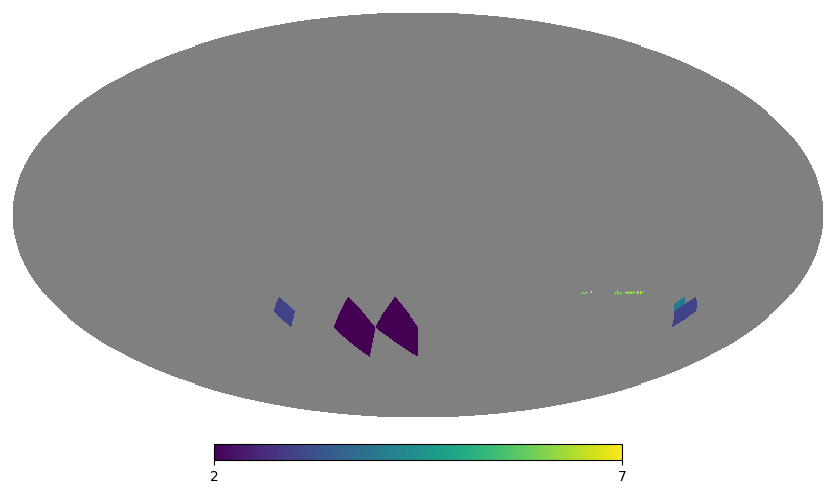

In [8]:
tiny_frame = merged_frame.loc[merged_frame["num_groups"]==1]
tiny_pixel_list = [HealpixPixel(int(row["Norder"]), int(row["Npix"]))
                  for _, row in tiny_frame.iterrows()]
plot_pixel_list(tiny_pixel_list)

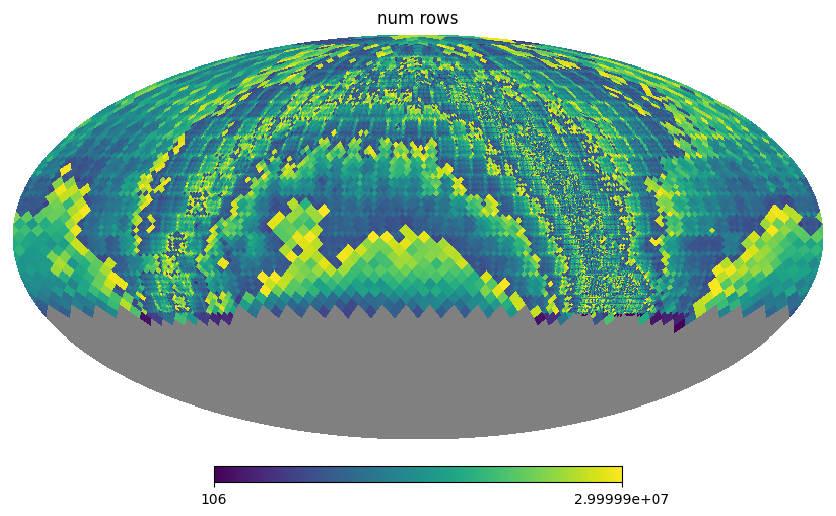

In [9]:
bigger_frame = merged_frame.loc[merged_frame["num_groups"]>5]
plot_sky_frame(bigger_frame, "num rows", "num_rows")

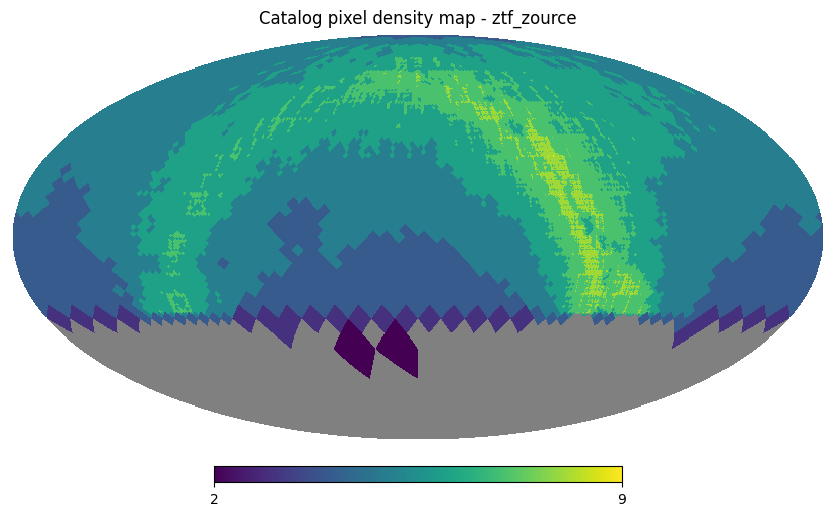

In [10]:
plot_pixels(catalog)